# **Zodiac Challenge + Conv Layers Visualization Challenge**

Let's first load the dataset.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os 
os.chdir('drive/My Drive/Practice Dataset')

In [0]:
!unzip signs

We should check if CUDA is available so we can train using GPU.

In [0]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


We're gonna use Nonechuks to make sure that our loaders will not load bad images unto our model. Then let's load in our train, test and validation datasets and apply transformations to it. We'll then put those in a loader.

In [0]:
!pip install nonechucks
import nonechucks as nc

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# choose the training and test datasets
train_data =  datasets.ImageFolder('signs/train', transform=transform)
test_data =  datasets.ImageFolder('signs/test', transform=transform)
valid_data =  datasets.ImageFolder('signs/valid', transform=transform)

train_data = nc.SafeDataset(train_data)
test_data = nc.SafeDataset(test_data)
valid_data = nc.SafeDataset(valid_data)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size, 
    num_workers=num_workers)

nonechucks may not work properly with this version of PyTorch (1.4.0). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


Let's enumerate the labels that we want our model to learn.

In [0]:
classes = ['dog', 'dragon', 'goat', 'horse', 'monkey', 'ox', 'pig', 'rabbit', 'ratt', 'rooster', 'snake', 'tiger']

Add in a function that will be used to display an image. (Normalized images will be un-normalized to see what they actually look like)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Let's have a peek at the dataset.

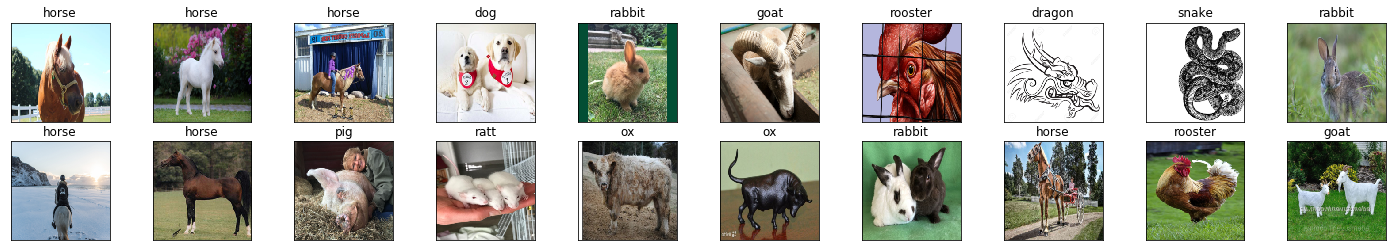

In [0]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

Let's load in our pre-trained model which is ResNext (https://arxiv.org/abs/1611.05431).

In [0]:

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = models.densenet121(pretrained=True)

model = models.resnext50_32x4d(pretrained=True)
# model = models.vgg16(pretrained=True)

To make sure that we don't perform backpropagation on the pretrained model's weights. We'll have to turn off requires_grad for every parameter.

In [0]:
for param in model.parameters():
    param.requires_grad = False

We'll modify the last layer of the model to fit our classification problem. I've decided to add a couple of fully connected layers. These fully connected layers will be trained.

In [0]:
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, len(classes)),
                                 nn.LogSoftmax(dim=1))

Let's initialize our loss criterion and our optimizer which is Adam.

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

model.to(device);

Let's add in the training loop. Let's make sure to save the model when it reaches its lowest validation loss.

In [0]:
import pandas as pd
epochs = 10
steps = 0
running_loss = 0
print_every = 5
train_stats = pd.DataFrame(columns = ['Epoch',  'Train loss',
                                      'Test loss'])
valid_loss_min = np.Inf

for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Valid loss: {test_loss/len(list(valid_loader)):.3f}.. "
                  f"Valid accuracy: {accuracy/len(list(valid_loader)):.3f}")
            train_stats = train_stats.append({'Epoch': epoch, 
                                              'Train loss' : running_loss/print_every,
                                     'Valid loss' : test_loss/batch_size}, ignore_index=True)
            
            if (test_loss/len(list(valid_loader))) <= valid_loss_min: # Check if our validation loss reached a new minimum
                print("Val loss decreased. Save model.")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = test_loss/len(list(valid_loader))
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 2.441.. Valid loss: 2.442.. Valid accuracy: 0.088
Val loss decreased. Save model.
Epoch 1/10.. Train loss: 2.444.. Valid loss: 2.415.. Valid accuracy: 0.083
Val loss decreased. Save model.
Epoch 1/10.. Train loss: 2.368.. Valid loss: 2.378.. Valid accuracy: 0.083
Val loss decreased. Save model.
Epoch 1/10.. Train loss: 2.373.. Valid loss: 2.343.. Valid accuracy: 0.083
Val loss decreased. Save model.
Epoch 1/10.. Train loss: 2.355.. Valid loss: 2.287.. Valid accuracy: 0.105
Val loss decreased. Save model.
Epoch 1/10.. Train loss: 2.293.. Valid loss: 2.244.. Valid accuracy: 0.292
Val loss decreased. Save model.
Epoch 1/10.. Train loss: 2.273.. Valid loss: 2.185.. Valid accuracy: 0.465
Val loss decreased. Save model.
Epoch 1/10.. Train loss: 2.199.. Valid loss: 2.116.. Valid accuracy: 0.574
Val loss decreased. Save model.
Epoch 1/10.. Train loss: 2.166.. Valid loss: 2.062.. Valid accuracy: 0.670
Val loss decreased. Save model.
Epoch 1/10.. Train loss: 2.123.. Vali

Let's plot our training and validation losses with respect to the amount of steps.

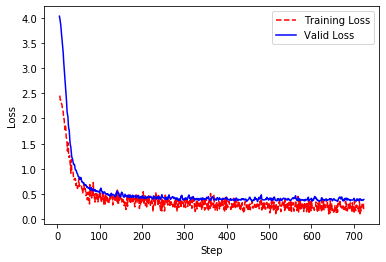

In [0]:
model.load_state_dict(torch.load('model.pt'))
step_count = []
training_loss = []
valid_loss = []

for i in train_stats.iterrows():
    step_count.append(i[0] + 1 * 5)
    training_loss.append(i[1]['Train loss'])
    valid_loss.append(i[1]['Valid loss'])

plt.plot(step_count, training_loss, 'r--')
plt.plot(step_count, valid_loss, 'b-')
plt.legend(['Training Loss', 'Valid Loss'])
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show();

Let's test our classifier to see how it performs on the test data which it has never seen before.

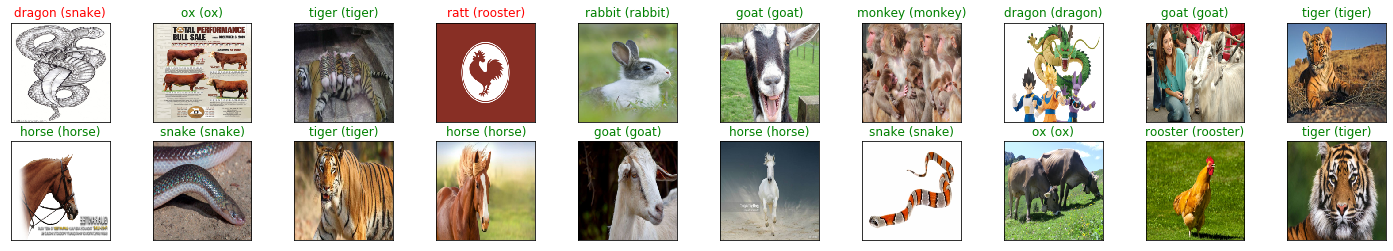

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

Let's make one full pass through the test dataset to check our accuracy.

In [0]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)
        
        test_loss += batch_loss.item()
        
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test loss: {test_loss/len(list(test_loader)):.3f}.. "
      f"Test accuracy: {accuracy/len(list(test_loader)):.3f}")

Test loss: 0.257.. Test accuracy: 0.915


We've got a test accuracy of 91.5% with our model. 
Let's then visualize the first couple of layers of our model to see how the filters look like when we're passing data to the model.
We'll be using Viztools by dingsheng-ong. We'll be using this library to visualize the activation value.

In [0]:
!!pip install git+https://github.com/dingsheng-ong/viztools-pytorch.git

['Collecting git+https://github.com/dingsheng-ong/viztools-pytorch.git',
 '  Cloning https://github.com/dingsheng-ong/viztools-pytorch.git to /tmp/pip-req-build-_zmf66mf',
 '  Running command git clone -q https://github.com/dingsheng-ong/viztools-pytorch.git /tmp/pip-req-build-_zmf66mf',
 'Requirement already satisfied (use --upgrade to upgrade): viztools==1.0.0 from git+https://github.com/dingsheng-ong/viztools-pytorch.git in /usr/local/lib/python3.6/dist-packages',
 'Requirement already satisfied: matplotlib in /usr/local/lib/python3.6/dist-packages (from viztools==1.0.0) (3.1.3)',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.6/dist-packages (from viztools==1.0.0) (1.17.5)',
 'Requirement already satisfied: torch in /usr/local/lib/python3.6/dist-packages (from viztools==1.0.0) (1.4.0)',
 'Requirement already satisfied: torchvision in /usr/local/lib/python3.6/dist-packages (from viztools==1.0.0) (0.5.0)',
 'Requirement already satisfied: cycler>=0.10 in /usr/local/

Let's import our dependencies and use defuse_model to check the layer names which we'll use later to identify convolutional layers.

In [0]:
from viztools.util import defuse_model
from pprint import pprint

layer_dict = defuse_model(model)
pprint(layer_dict)

OrderedDict([('Conv2d-1',
              Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
             ('BatchNorm2d-1',
              BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('ReLU-1', ReLU(inplace=True)),
             ('MaxPool2d-1',
              MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
             ('Conv2d-2',
              Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)),
             ('BatchNorm2d-2',
              BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('Conv2d-3',
              Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)),
             ('BatchNorm2d-3',
              BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('Conv2d-4',
              Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bia

Let's take one image from our test_loader to feed to our model. We'll use this cute dog over here.

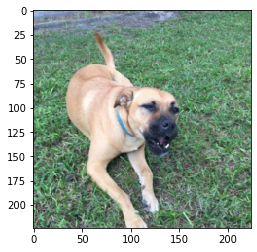

In [0]:
from viztools import viz_act_val
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from viztools import viz_back_prop


for test_images, test_labels in test_loader:  
    sample_image = test_images[0]
    imshow(test_images.cpu()[0])
    break

Let's then feed our image to the model and see how the first convolutional layer's acivation values looks like.

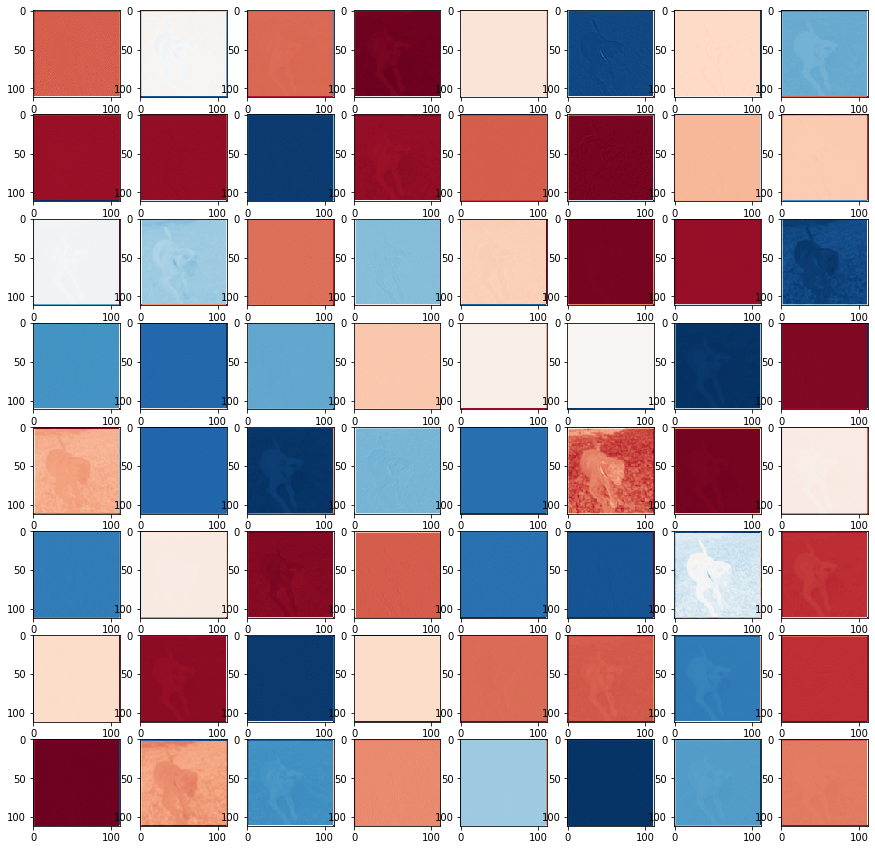

In [0]:
model.to('cpu');

from viztools.util import (
    defuse_model,
    assert_numpy_image,
    insert_flatten_layer,
    normalize_image,
    convert_image_tensor
)

def viz_act_val(image, model, layer, kernel):
    """
    Record activation values of each layer and return them as OrderedDict

    Args:
        image            : (np.ndarray) input image
        model            : (nn.Module) PyTorch pretrained model
        layer            : (str) target layer
        kernel           : (int) target kernel
    Returns:
        activation_value : (np.ndarray) activation value in array
    """
    assert_numpy_image(image)
    assert isinstance(model, nn.Module), "'module' is not nn.Module"
    layers = defuse_model(model)
    assert layer in layers.keys(), f"'{layer}' not in 'model'"
    # insert Flatten layer if needed
    if "Linear-1" in layers.keys(): layers = insert_flatten_layer(layers)
    # preprocess image
    image = convert_image_tensor(normalize_image(image))
    
    # activation_values = OrderedDict()
    # activation_values["input"] = [
    #     image[0, c].data.numpy() for c in range(image.size()[1])
    # ]
    for tag, module in layers.items():
        image = module(image)
        if tag == layer:
            assert kernel < image.size()[1], "'kernel' out of bound"
            activation = image[0, kernel].data.numpy()
            activation -= activation.min()
            activation /= activation.max()
            return activation

        # activation_values[tag] = []
        # for channel in range(image.size()[1]):
        #     img = image[0, channel].data.numpy()
        #     img -= img.min()
        #     img /= img.max()
        #     activation_values[tag].append(img)

    # return activation_values
f, axarr = plt.subplots(8,8,figsize=(15,15))

for i in range(8):
    for m in range(8):
        activation_value = viz_act_val(sample_image.permute(1,2,0).numpy(), model, "Conv2d-1", m + (i * 8))
        axarr[i][m].imshow(activation_value, cmap=plt.cm.RdBu_r)

plt.show()

Let's then look at the convolutional second layer.

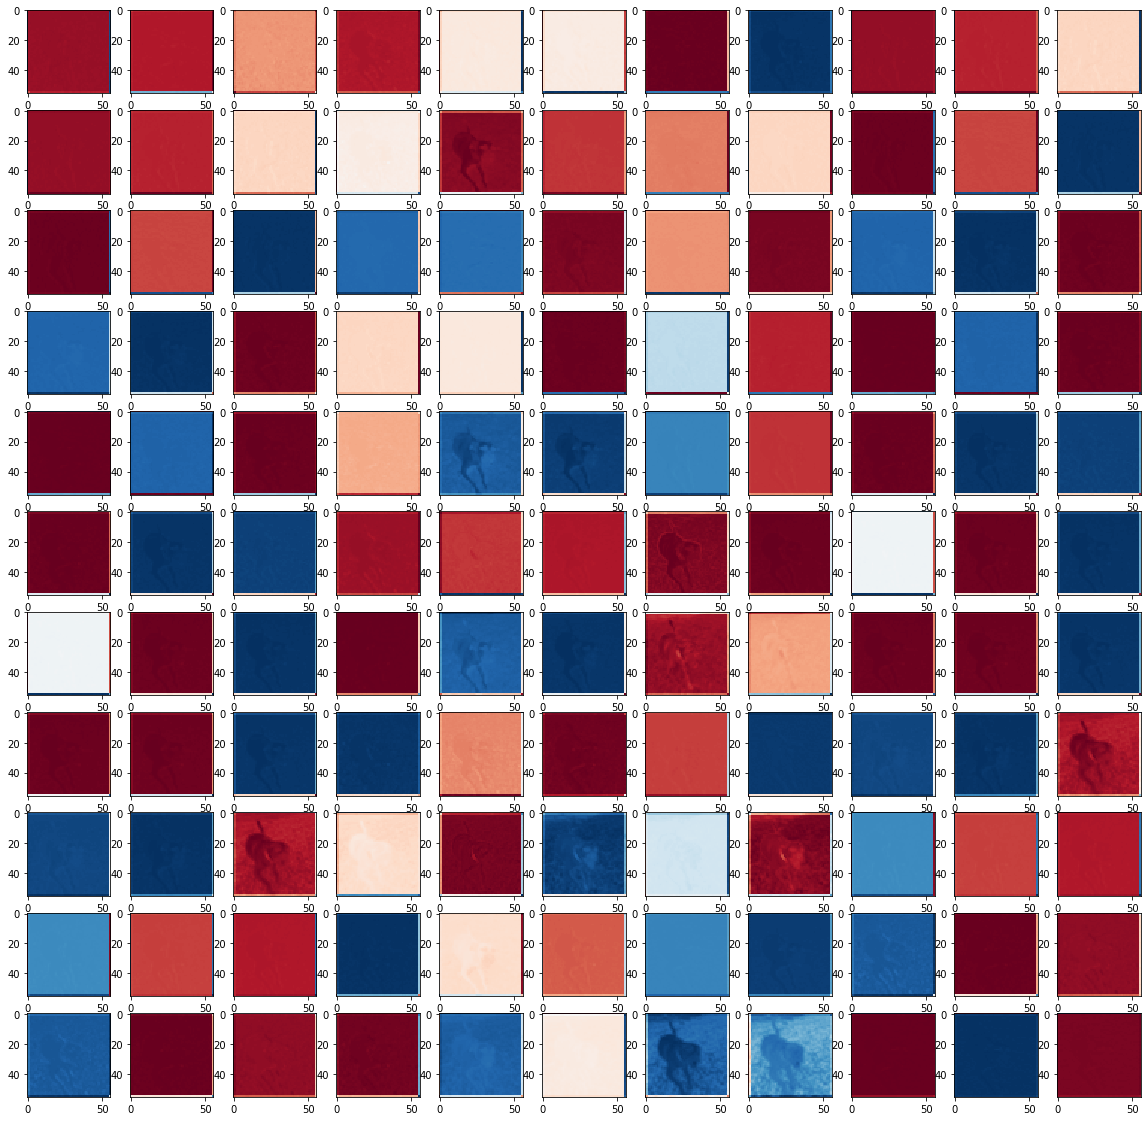

In [0]:
f, axarr = plt.subplots(11,11,figsize=(20,20))

for i in range(11):
    for m in range(11):
        activation_value = viz_act_val(sample_image.permute(1,2,0).numpy(), model, "Conv2d-2", m + (i * 8))
        axarr[i][m].imshow(activation_value, cmap=plt.cm.RdBu_r)

plt.show()

The third convolutional layer.

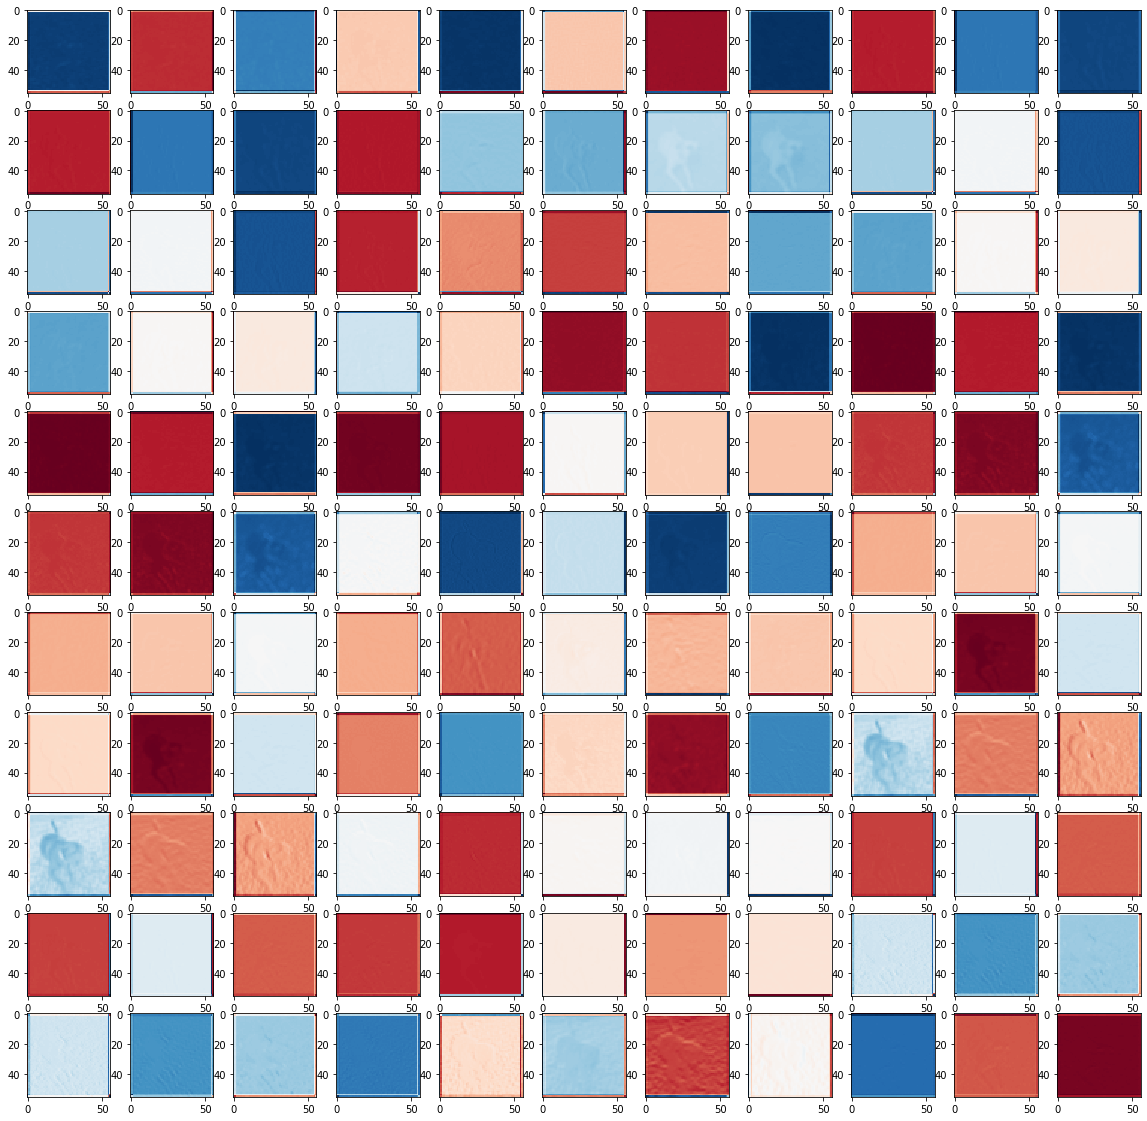

In [0]:
f, axarr = plt.subplots(11,11,figsize=(20,20))

for i in range(11):
    for m in range(11):
        activation_value = viz_act_val(sample_image.permute(1,2,0).numpy(), model, "Conv2d-3", m + (i * 8))
        axarr[i][m].imshow(activation_value, cmap=plt.cm.RdBu_r)

plt.show()

The fourth convolutional layer.

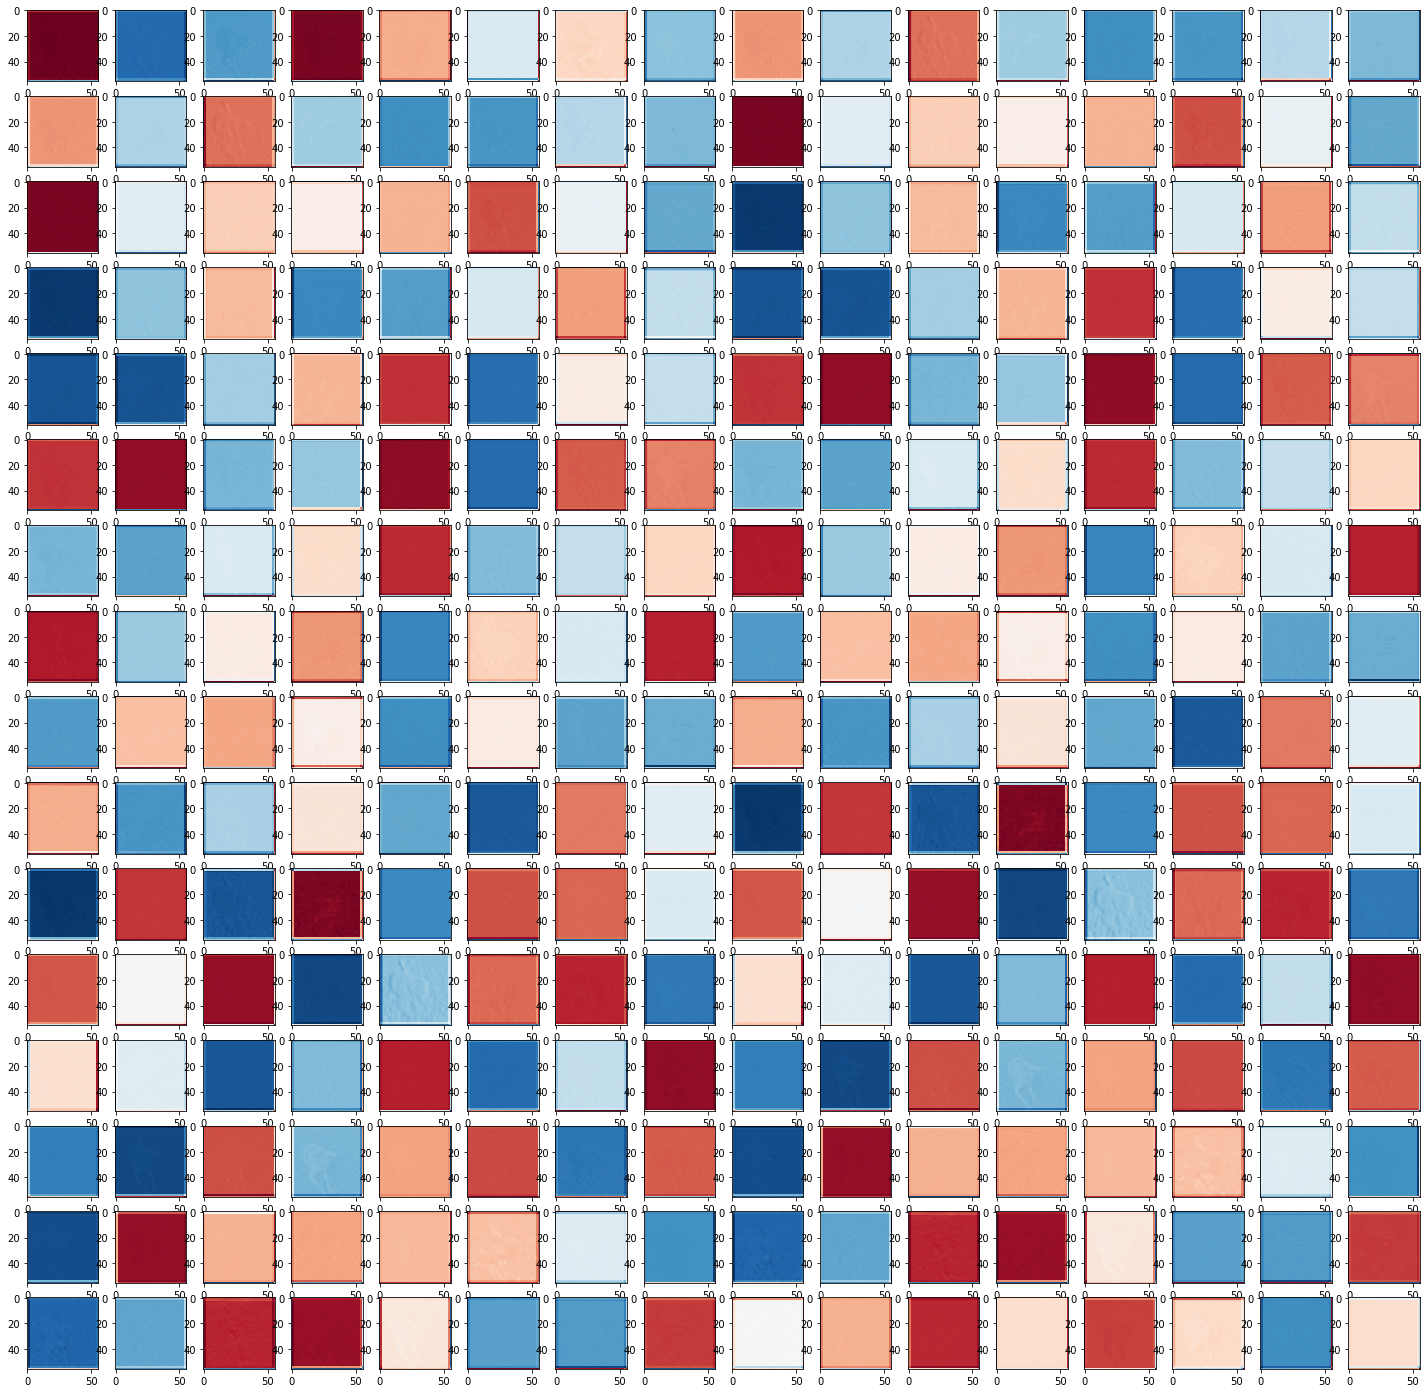

In [0]:
f, axarr = plt.subplots(16,16,figsize=(25,25))

for i in range(16):
    for m in range(16):
        activation_value = viz_act_val(sample_image.permute(1,2,0).numpy(), model, "Conv2d-4", m + (i * 8))
        axarr[i][m].imshow(activation_value, cmap=plt.cm.RdBu_r)

plt.show()